In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.signal import correlate2d, convolve2d

In [11]:
# neural networks stuff: 


class convolutional_layer():
    def __init__(self, input_shape, kernel_size, depth):
        
        # input_shape = (depth, width, height) of each input
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.input_depth = input_depth
        
        
        # depth = number of kernels
        self.depth = depth
        
        # output shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        
        # initialize kernels (weights) and biases
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.weights = 0.1*np.random.randn(depth, input_depth, kernel_size, kernel_size)
        self.biases = np.zeros(self.output_shape)

        # initialize momentums and caches (for ADAM)
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    def forward(self, inputs):
        
        # save inputs
        self.inputs = inputs
        
        # initialize output array
        self.output = np.copy(self.biases)
        
        # loop over kernels
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += correlate2d(self.inputs[j], self.weights[i, j], "valid")
                
    def backward(self, dinputs):

        # initialize gradients
        self.dweights = np.zeros(self.kernels_shape) # weights = kernels Kij
        self.dinputs = np.zeros(self.input_shape)
        self.dbiases = dinputs
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.dweights[i, j] = correlate2d(self.inputs[j], dinputs[i], "valid")
                self.dinputs[j] += convolve2d(dinputs[i], self.weights[i, j], "full")


class reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs):
        self.output = np.reshape(inputs, self.output_shape)

    def backward(self, dinputs):
        self.dinputs = np.reshape(dinputs, self.input_shape)
        
class maxpool2:
  # A Max Pooling layer using a pool size of 2.

    def iterate_regions(self, image):
        # Generates non-overlapping 2x2 image regions to pool over.
        
        
        
        _, h, w = image.shape

        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                region = image[:, (2*i):(2*i + 2), (2*j):(2*j + 2)]
                yield region, i, j

    def forward(self, inputs):

        self.inputs = inputs
        depth, h, w = inputs.shape
        self.output = np.zeros((depth, h // 2, w // 2))

        for region, i, j in self.iterate_regions(inputs):
            self.output[:, i, j] = np.max(region, axis=(1, 2))

    
    def backward(self, dinputs):
 
        self.dinputs = np.zeros(self.inputs.shape)

        for region, i, j in self.iterate_regions(self.inputs):
            d, h, w = region.shape
            max_idx = region.reshape(d,-1).argmax(axis=1)
            max_pos = np.column_stack(np.unravel_index(max_idx, (h,w)))
            self.dinputs[:, (2*i):(2*i + 2), (2*j):(2*j + 2)][np.arange(d),max_pos[:,0],max_pos[:,1]] = dinputs[:,i,j]
            
            
# recurrent layer
class recurrent_layer:
    
    
    def __init__(self,n_inputs, n_neurons): 
        
        # initialization (weights and biases)
        self.weights = 0.1*np.random.randn(n_inputs+n_neurons,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
        # save sizes
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
        
    # forward pass: pass the data through the layer
    def forward(self, inputs1, inputs2):
        # save inputs
        self.inputs1 = inputs1
        self.inputs2 = inputs2
        self.inputs = np.c_[inputs1,inputs2]
        
        # output
        self.output = self.inputs.dot(self.weights) + self.biases
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)[:,0:self.n_inputs]
            
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        
# linear activation function: outputs = inputs
class linear:

    def forward(self, inputs):
        # flatten the output
        self.inputs = inputs
        self.output = inputs.flatten()

    def backward(self, dinputs):
        # derivative of x is 1 
        self.dinputs = dinputs.copy().reshape(-1,1) # reshape the result as a column vector
        
# mean squeared error        
class loss_mse():

    def forward(self, y_pred, y_true):

    # calculate loss
        sample_losses = (y_true - y_pred)**2
        # return losses
        return sample_losses

    def backward(self, y_pred, y_true):

        # number of data points
        samples = len(y_pred)

        # gradient 
        self.dinputs = -2 * (y_true - y_pred) 

        # normalize gradient
        self.dinputs = self.dinputs / samples
        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / np.clip(p,a_min=1e-200,a_max=1)
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
    
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

# Problem 1: The "quick, draw!" dataset

In [3]:
# load training data
data = pd.read_csv('data_train.csv')
X = data.drop('label',axis=1).to_numpy()/255
y = data['label'].to_numpy('int')

In [4]:
# load testing data
data_test = pd.read_csv('data_test.csv')
X_test = data_test.drop('label',axis=1).to_numpy()/255
y_test = data_test['label'].to_numpy('int')

Each example is a 28x28 grayscale image, associated with a label from 5 classes. 
The following figure shows a few images from the dataset.

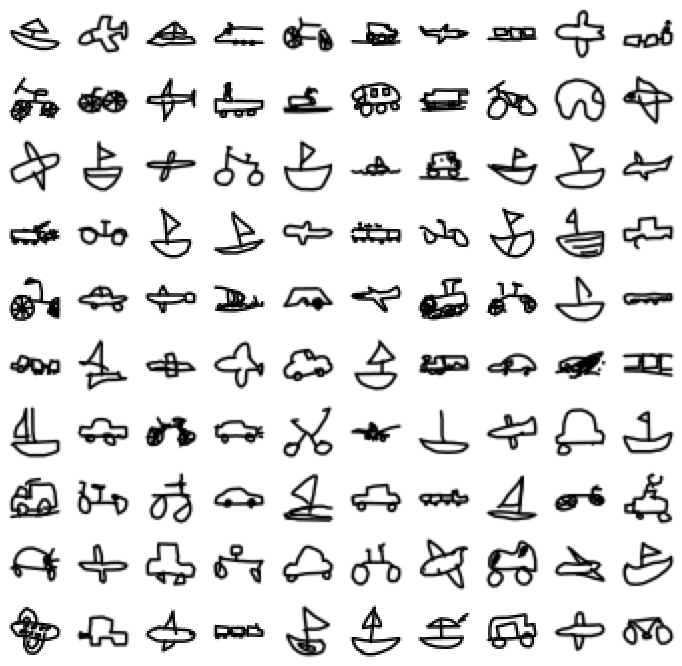

In [5]:
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X[i].reshape(28,28),cmap='binary')
    plt.axis('off')    

**Labels:**

| label | description |
| ----------- | ----------- |
| 0 | airplane |
| 1 | bicycle |
| 2 | car |
| 3 | sail boat |
| 4 | train |

**The goal** is to achieve ~80% accuracy on the testing set

In [7]:
X = X.reshape(5000,1,28,28)

In [23]:
# build a convolutional neural network

# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=3, depth=32) # output size = (32,26,26)
activation1 = ReLU()
pooling1 = maxpool2() # output size = (16,13,13)

# layer 2
layer2 = reshape(input_shape=(32,13,13), output_shape=(1,32*13*13)) 
dropout2 = dropout(0.5)

# layer 3
layer3 = layer(n_inputs = 32 * 13 * 13, n_neurons = 5)
activation3 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)

In [24]:
# fit the neural network to the training data 

n_epochs = 40
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)
        pooling1.forward(activation1.output)
        
        layer2.forward(pooling1.output)
        dropout2.forward(layer2.output)
        
        layer3.forward(dropout2.output)
        activation3.forward(layer3.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation3.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation3.output,axis=1)
        

        # backward pass
        loss_function.backward(activation3.output,y[i].reshape(1))
        activation3.backward(loss_function.dinputs)
        layer3.backward(activation3.dinputs)

        dropout2.backward(layer3.dinputs)
        layer2.backward(dropout2.dinputs)
        
        pooling1.backward(layer2.dinputs)
        activation1.backward(pooling1.dinputs)
        layer1.backward(activation1.dinputs)



        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer3)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

epoch: 0
loss: 2.856
accuracy: 63.019999999999996
------------------------
epoch: 1
loss: 2.486
accuracy: 70.06
------------------------
epoch: 2
loss: 2.326
accuracy: 72.82
------------------------
epoch: 3
loss: 2.377
accuracy: 73.32
------------------------
epoch: 4
loss: 2.191
accuracy: 75.36
------------------------
epoch: 5
loss: 2.278
accuracy: 75.33999999999999
------------------------
epoch: 6
loss: 2.071
accuracy: 77.52
------------------------
epoch: 7
loss: 2.064
accuracy: 79.4
------------------------
epoch: 8
loss: 2.079
accuracy: 79.17999999999999
------------------------
epoch: 9
loss: 2.037
accuracy: 80.58
------------------------
epoch: 10
loss: 2.034
accuracy: 81.36
------------------------
epoch: 11
loss: 2.047
accuracy: 81.76
------------------------
epoch: 12
loss: 1.923
accuracy: 83.14
------------------------
epoch: 13
loss: 1.875
accuracy: 83.86
------------------------
epoch: 14
loss: 1.929
accuracy: 83.86
------------------------
epoch: 15
loss: 1.738
accurac

In [17]:
X_test = X_test.reshape((len(X_test),1,28,28))

In [27]:
# Test your neural network on the test set.
y_test_pred = np.zeros(len(X_test))
for i in range(len(X_test)):

    # forward pass
    layer1.forward(X_test[i])
    activation1.forward(layer1.output)
    pooling1.forward(activation1.output)

    layer2.forward(pooling1.output)
    dropout2.forward(layer2.output)

    layer3.forward(dropout2.output)
    activation3.forward(layer3.output)


    # prediction
    y_test_pred[i] = np.argmax(activation3.output,axis=1)

In [28]:
# accuracy
np.mean(y_test==y_test_pred)

0.8242

## Smaller

In [ ]:
# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=3, depth=16) # output size = (16,26,26)
activation1 = ReLU()
pooling1 = maxpool2() # output size = (16,13,13)

# layer 2
layer2 = reshape(input_shape=(16,13,13), output_shape=(1,16*13*13)) 
dropout2 = dropout(0.3)

# layer 3
layer3 = layer(n_inputs = 16 * 13 * 13, n_neurons = 5)
activation3 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)

In [ ]:
n_epochs = 20
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)
        pooling1.forward(activation1.output)
        
        layer2.forward(pooling1.output)
        dropout2.forward(layer2.output)
        
        layer3.forward(dropout2.output)
        activation3.forward(layer3.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation3.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation3.output,axis=1)
        

        # backward pass
        loss_function.backward(activation3.output,y[i].reshape(1))
        activation3.backward(loss_function.dinputs)
        layer3.backward(activation3.dinputs)

        dropout2.backward(layer3.dinputs)
        layer2.backward(dropout2.dinputs)
        
        pooling1.backward(layer2.dinputs)
        activation1.backward(pooling1.dinputs)
        layer1.backward(activation1.dinputs)



        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer3)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

In [ ]:
X.max()

In [ ]:
data = pd.read_csv('data_test.csv')
X_test = data.drop('label',axis=1).to_numpy()/255
y_test = data['label'].to_numpy('int')

In [ ]:
X_test = X_test.reshape((len(X_test),1,28,28))

In [ ]:
X_test.shape

In [ ]:
y_test_pred = np.zeros(len(X_test))
for i in range(len(X_test)):

    # forward pass
    layer1.forward(X_test[i])
    activation1.forward(layer1.output)
    pooling1.forward(activation1.output)

    layer2.forward(pooling1.output)
    dropout2.forward(layer2.output)

    layer3.forward(dropout2.output)
    activation3.forward(layer3.output)


    # prediction
    y_test_pred[i] = np.argmax(activation3.output,axis=1)

In [ ]:
np.mean(y_test==y_test_pred)

In [ ]:
C = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        C[i,j] = np.sum(y_test[y_test_pred==i]==j)
C